# Tutorial 05

## fore-/back-ground models

following 

Planck 2018 results. XI. Polarized dust foregrounds
https://doi.org/10.1051/0004-6361/201832618

and

Polarized galactic synchrotron and dust emission and their correlation
https://doi.org/10.1088/1475-7516/2015/12/020

#### frequency scaling

this would use the `bandpower` function, which takes a frequency list (in GHz) as input,
the return gives an array in shape 
```
(angular mode size, frequency size, frequency size)
```

- synchrotron

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_s} br(\nu_1,\nu_0)br(\nu_2,\nu_0)$$

$$ br(\nu,\nu_0) = \left(\frac{\nu_0}{\nu}\right)^4 e^{(x_0-x)} \left(\frac{e^x-1}{e^{x_0}-1}\right)^2 $$

$$ x(\nu) = \frac{h\nu}{k_\mathrm{B} T_0}, T_0 \approx 2.73 \mathrm{K}$$

with Planck reference, $\nu_0 = 30$ GHz, the function $br(\nu,\nu_0)$ originated from converting emission brightness into CMB thermal temperature.

- thermal dust

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_d} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} br(\nu_1,\nu_0)br(\nu_2,\nu_0)$$

with Planck reference, we take $\nu_0=353$ GHz, $T_d = 19.6$ K.

- synchrotron-dust

$$ \frac{\mathcal{D}^{XX}_\ell(\nu_1,\nu_2)}{br(\nu_1,\nu_0)br(\nu_2,\nu_0)} = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0s}} \right)^{\beta_s} + \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_{0d}} \right)^{\beta_d} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + \rho^{XX} \sqrt{\mathcal{A}^{XX}_{s,\ell}\mathcal{A}^{XX}_{d,\ell}} \left( (\frac{\nu_1}{\nu_{0s}})^{\beta_s}(\frac{\nu_2}{\nu_{0d}})^{\beta_d}\frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)} + (\frac{\nu_2}{\nu_{0s}})^{\beta_s}(\frac{\nu_1}{\nu_{0d}})^{\beta_d}\frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)}\right)$$

with Planck reference, $\nu_{0s} = 30$ GHz, $\nu_{0d} = 353$ GHz.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

map30f = hp.smoothing(map30f,fwhm=fwhm[0],verbose=0)
map95f = hp.smoothing(map95f,fwhm=fwhm[1],verbose=0)
map150f = hp.smoothing(map150f,fwhm=fwhm[2],verbose=0)
map353f = hp.smoothing(map353f,fwhm=fwhm[3],verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### synchrotron model

- T mode

{'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

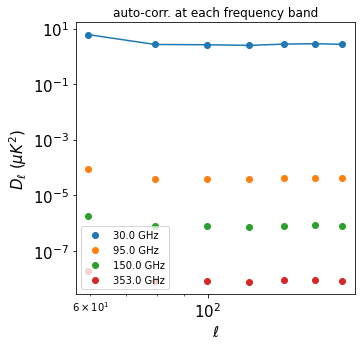

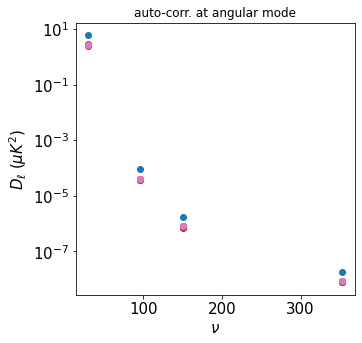

In [2]:
from afra.tools.fg_models import syncmodel

FREQS = [30.,95.,150.,353.]
TARGET = 'T'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {30:map30f}
fullbeam = {30:0.5*np.pi/180.}

s = syncmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=fullmap,template_fwhms=fullbeam)
s.reset({'beta_s':-3.})
bp = s.bandpower()
print (s.params)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = s.est.autoBP(fullmap[30],fwhms=fullbeam[30])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(s.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

{'beta_s': -3.0}


Text(0.5, 1.0, 'auto-corr. at angular mode')

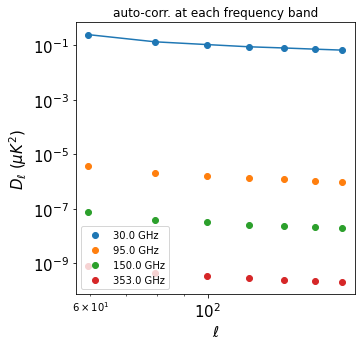

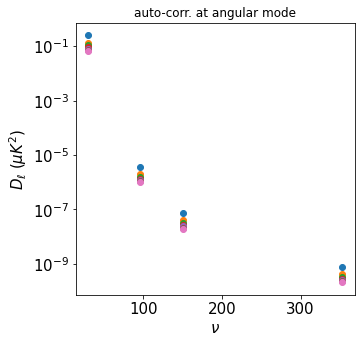

In [3]:
FREQS = [30.,95.,150.,353.]
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {30:map30f}
fullbeam = {30:0.5*np.pi/180.}

s = syncmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=fullmap,template_fwhms=fullbeam)
s.reset({'beta_s':-3.})
bp = s.bandpower()
print (s.params)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = s.est.autoBP(fullmap[30],fwhms=fullbeam[30])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(s.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### thermal dust model

- T mode

['beta_d']
{'beta_d': 1.5}
{'beta_d': [0.0, 5.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

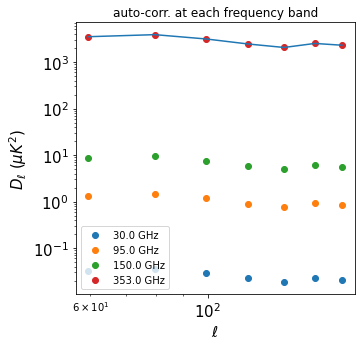

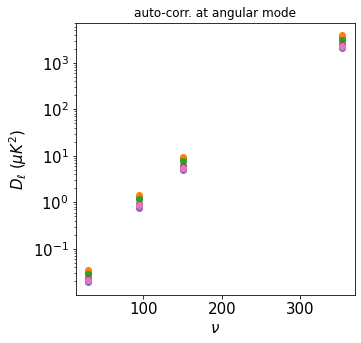

In [4]:
from afra.tools.fg_models import dustmodel

FREQS = [30.,95.,150.,353.]
TARGET = 'T'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {353:map353f}
fullbeam = {353:0.08*np.pi/180.}

d = dustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=fullmap,template_fwhms=fullbeam)

d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.param_list)
print (d.params)
print (d.param_range)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = d.est.autoBP(fullmap[353],fwhms=fullbeam[353])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(d.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

['beta_d']
{'beta_d': 1.5}
{'beta_d': [0.0, 5.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

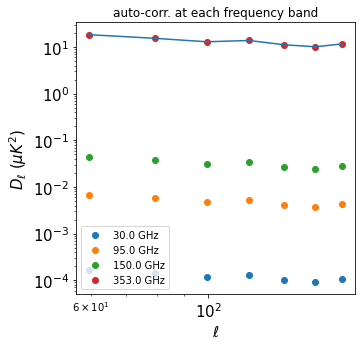

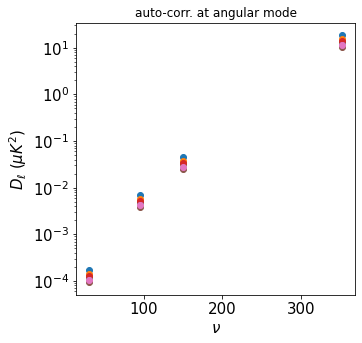

In [5]:
FREQS = [30.,95.,150.,353.]
#FREQS = list(np.linspace(5,400,30))
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {353:map353f}
fullbeam = {353:0.08*np.pi/180.}

d = dustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=fullmap,template_fwhms=fullbeam)

d.reset({'beta_d':1.5})
bp = d.bandpower()
print (d.param_list)
print (d.params)
print (d.param_range)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = d.est.autoBP(fullmap[353],fwhms=fullbeam[353])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(d.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(s.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### synchrotron-dust correlated

- T mode

['beta_s', 'beta_d', 'rho']
{'beta_s': -3, 'beta_d': 1.5, 'rho': 0.0}
{'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

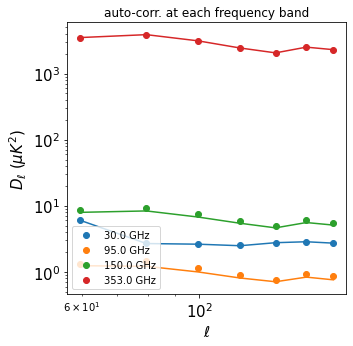

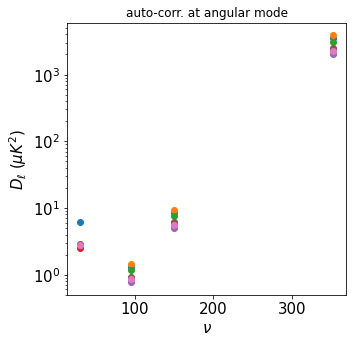

In [6]:
from afra.tools.fg_models import syncdustmodel

FREQS = [30.,95.,150.,353.]
TARGET = 'T'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {30:map30f,353:map353f}
fullbeam = {30:0.5*np.pi/180.,353:0.08*np.pi/180.}

c = syncdustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                  templates=fullmap,template_fwhms=fullbeam)
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.param_list)
print (c.params)
print (c.param_range)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = c.est.autoBP(fullmap[30],fwhms=fullbeam[30])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(map95f,fwhms=fwhm[1])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(map150f,fwhms=fwhm[2])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(fullmap[353],fwhms=fullbeam[353])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(c.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(c.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode

['beta_s', 'beta_d', 'rho']
{'beta_s': -3, 'beta_d': 1.5, 'rho': 0.0}
{'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

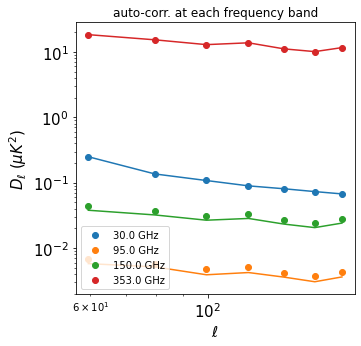

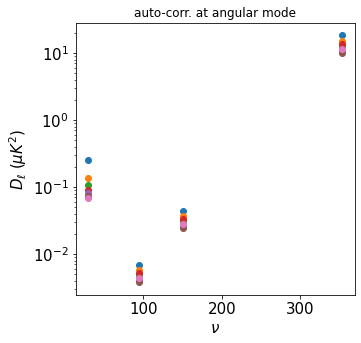

In [7]:
FREQS = [30.,95.,150.,353.]
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = {30:map30f,353:map353f}
fullbeam = {30:0.5*np.pi/180.,353:0.08*np.pi/180.}

c = syncdustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                  templates=fullmap,template_fwhms=fullbeam)
c.reset({'beta_s':-3})
c.reset({'beta_d':1.5})
bp = c.bandpower()
print (c.param_list)
print (c.params)
print (c.param_range)

fig,ax = plt.subplots(figsize=(5,5))

fiducial_dl = c.est.autoBP(fullmap[30],fwhms=fullbeam[30])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(map95f,fwhms=fwhm[1])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(map150f,fwhms=fwhm[2])
ax.plot(fiducial_dl[0],fiducial_dl[1])
fiducial_dl = c.est.autoBP(fullmap[353],fwhms=fullbeam[353])
ax.plot(fiducial_dl[0],fiducial_dl[1])

for j in range(len(FREQS)):
    ax.scatter(c.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(c.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### non-parametric CMB model

- T mode


 param name list ['bp_c_T_59.499999999999986', 'bp_c_T_79.49999999999999', 'bp_c_T_99.49999999999999', 'bp_c_T_119.49999999999999', 'bp_c_T_139.49999999999997', 'bp_c_T_159.49999999999997', 'bp_c_T_179.49999999999994']

 param values {'bp_c_T_59.499999999999986': 5000.0, 'bp_c_T_79.49999999999999': 5000.0, 'bp_c_T_99.49999999999999': 5000.0, 'bp_c_T_119.49999999999999': 5000.0, 'bp_c_T_139.49999999999997': 5000.0, 'bp_c_T_159.49999999999997': 5000.0, 'bp_c_T_179.49999999999994': 5000.0}

 param range {'bp_c_T_59.499999999999986': [0.0, 10000.0], 'bp_c_T_79.49999999999999': [0.0, 10000.0], 'bp_c_T_99.49999999999999': [0.0, 10000.0], 'bp_c_T_119.49999999999999': [0.0, 10000.0], 'bp_c_T_139.49999999999997': [0.0, 10000.0], 'bp_c_T_159.49999999999997': [0.0, 10000.0], 'bp_c_T_179.49999999999994': [0.0, 10000.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

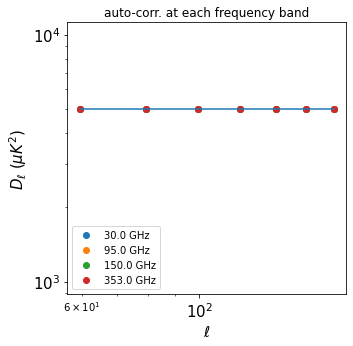

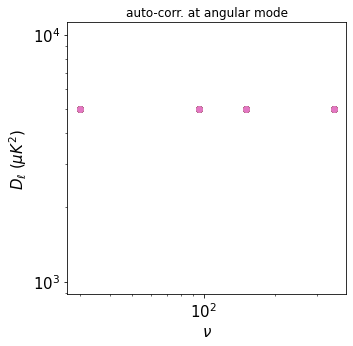

In [8]:
from afra.tools.bg_models import cmbmodel

FREQS = [30.,95.,150.,353.]
TARGET = 'T'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

b = cmbmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(b.modes,[0.5e+4]*len(b.modes))

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

- B mode


 param name list ['bp_c_B_59.499999999999986', 'bp_c_B_79.49999999999999', 'bp_c_B_99.49999999999999', 'bp_c_B_119.49999999999999', 'bp_c_B_139.49999999999997', 'bp_c_B_159.49999999999997', 'bp_c_B_179.49999999999994']

 param values {'bp_c_B_59.499999999999986': 5000.0, 'bp_c_B_79.49999999999999': 5000.0, 'bp_c_B_99.49999999999999': 5000.0, 'bp_c_B_119.49999999999999': 5000.0, 'bp_c_B_139.49999999999997': 5000.0, 'bp_c_B_159.49999999999997': 5000.0, 'bp_c_B_179.49999999999994': 5000.0}

 param range {'bp_c_B_59.499999999999986': [0.0, 10000.0], 'bp_c_B_79.49999999999999': [0.0, 10000.0], 'bp_c_B_99.49999999999999': [0.0, 10000.0], 'bp_c_B_119.49999999999999': [0.0, 10000.0], 'bp_c_B_139.49999999999997': [0.0, 10000.0], 'bp_c_B_159.49999999999997': [0.0, 10000.0], 'bp_c_B_179.49999999999994': [0.0, 10000.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

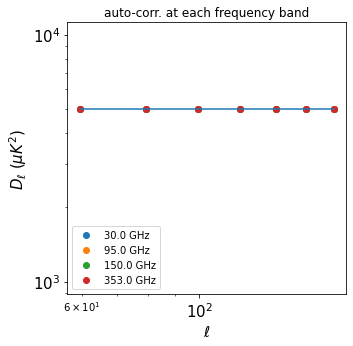

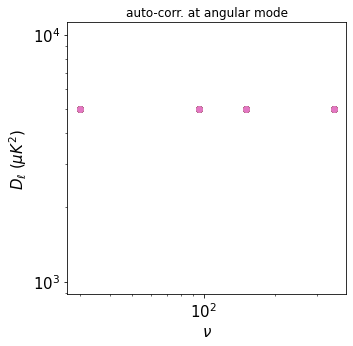

In [9]:
FREQS = [30.,95.,150.,353.]
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

b = cmbmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(b.modes,[0.5e+4]*len(b.modes))

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### parametric CMB model

- B mode


 param name list ['r', 'Lb']

 param values {'r': 0.05, 'Lb': 1.0}

 param range {'r': [0.0, 1.0], 'Lb': [0.0, 2.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

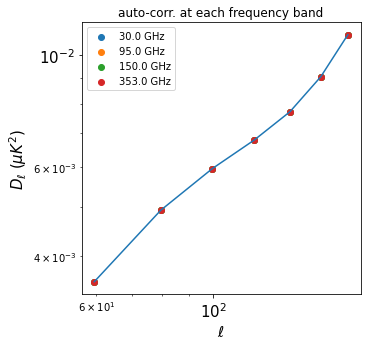

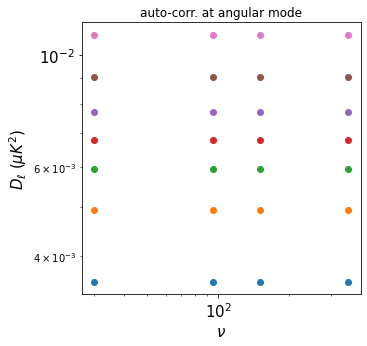

In [10]:
from afra.tools.bg_models import cambmodel

FREQS = [30.,95.,150.,353.]
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,target=TARGET)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
cmb_dl = np.zeros((4,len(est.modes)))
cmb_dl[0] = est.modes
for i in range(len(est.modes)):
    lrange = np.array(est._b.get_ell_list(i))
    factor = 0.5*lrange*(lrange+1)/np.pi
    w = np.array(est._b.get_weight_list(i))
    for j in range(3):
        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

b = cambmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[3])

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

#### unlensed B mode


 param name list ['r', 'Lb']

 param values {'r': 0.05, 'Lb': 0.0}

 param range {'r': [0.0, 1.0], 'Lb': [0.0, 2.0]}


Text(0.5, 1.0, 'auto-corr. at angular mode')

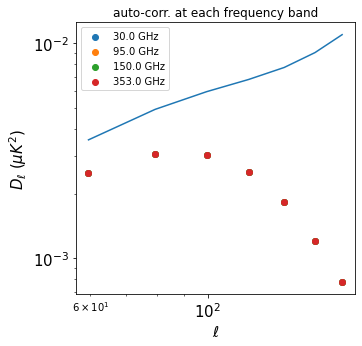

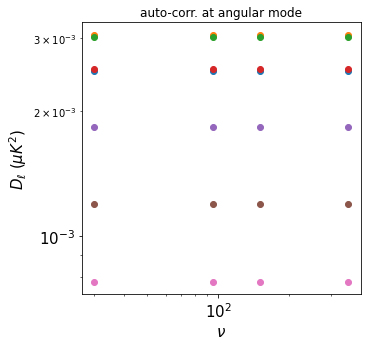

In [11]:
FREQS = [30.,95.,150.,353.]
TARGET = 'B'
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

b = cambmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
b.reset({'Lb':0.})
bp = b.bandpower()
print ('\n param name list', b.param_list)
print ('\n param values', b.params)
print ('\n param range', b.param_range)

fig,ax = plt.subplots(figsize=(5,5))

ax.plot(cmb_dl[0],cmb_dl[3])

for j in range(len(FREQS)):
    ax.scatter(b.modes,bp[:,j,j],label=str(FREQS[j])+' GHz')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at each frequency band')

fig,ax = plt.subplots(figsize=(5,5))

for i in range(len(b.modes)):
    ax.scatter(FREQS,np.diag(bp[i]))
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\nu$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('auto-corr. at angular mode')

end